In [1]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns #% matplotlib inline
import csv

In [2]:
#Define all functions

def UnstackImages(directory,infile,outfilenames):
    """
    Save the slices of a stack as separate images.
    """
    
    # Open the stacked TIFF image using PIL
    stacked_img = Image.open(directory+infile)

    # Extract individual images from the stacked image
    for num in range(len(outfilenames)):
        try:
            stacked_img.seek(num)  # Move to the next frame
            # Copy the frame to a new image and append to the list
            individual_image = stacked_img.copy()
            individual_image.save(directory+outfilenames[num])
        except EOFError:
            # No more images in the stack
            pass


def classifyDroplets(directory, img_filename, fluor_filename,
                     darkfield = None,
                     flatfield = None,
                     flatfield_fluor = None,
                     binary_threshold = 155,
                     apply_vignette_mask = False,
                     image_mask_radius = 1,
                     image_mask_x_offset = 0,
                     image_mask_y_offset = 0,
                     circles_dp = 1,
                     circles_min_dist = 55,
                     circles_param1 = 1,
                     circles_param2 = 10,
                     circles_min_radius = 22,
                     circles_max_radius = 40,
                     edge_band = 10,
                     intensity_cutoff1 = 0,
                     intensity_cutoff2 = 5000,
                     pixel_to_um = 1.001,
                     showfigs = False):
    """
    Read in a pair of brightfield and fluorescence image, identify particles, and classify emulsions.
    Note, differentiation between double and single emulsions is not reliable.
    The reliable differentiation is between triple emulsions and not-triple emulsions.
    """
    
    #Track if images are darkfield or flatfield corrected
    corrected = False
    
    #Set parameters
    img_path = directory + img_filename 
    fluor_path = directory + fluor_filename

    # Load the TIF images -- Bright field and fluorescence channels
    pil_img = Image.open(img_path)
    pil_fluor = Image.open(fluor_path)
    img = np.array(pil_img)
    img = img.astype(np.uint16)
    fluor = np.array(pil_fluor)
    fluor = fluor.astype(np.uint16)
    loaded_img = Image.fromarray(img)
    loaded_img.save(directory+"Loaded_Brightfield.tif")
    loaded_fluor = Image.fromarray(fluor)
    loaded_fluor.save(directory+"Loaded_NileRed.tif")
    
    #Apply darkfield subtraction
    if darkfield != None:
        corrected = True
        pil_background = Image.open(darkfield)
        background_img = np.array(pil_background)
        background_img = background_img.astype(np.uint16)
        img = img-background_img
        fluor = fluor-background_img
    
    #Apply flatfield correction to brightfield image
    if flatfield != None:
        corrected = True
        pil_flatfield = Image.open(flatfield)
        flatfield_img = np.array(pil_flatfield)
        flatfield_img = flatfield_img.astype(np.float64) 
        flatfield_norm = flatfield_img/np.mean(flatfield_img)
        img = img.astype(np.float64)
        img = img/flatfield_norm
        img = np.clip(img, 0, 65535)
        img = img.astype(np.uint16)

    #Apply flatfield correction to fluoresence image
    if flatfield_fluor != None:
        corrected = True
        pil_flatfield_fluor = Image.open(flatfield_fluor)
        flatfield_img_fluor = np.array(pil_flatfield_fluor)
        flatfield_img_fluor = flatfield_img_fluor.astype(np.float64)
        flatfield_norm_fluor = flatfield_img_fluor/np.mean(flatfield_img_fluor)
        fluor = fluor.astype(np.float64)
        fluor = fluor/flatfield_norm_fluor
        fluor = np.clip(fluor, 0, 65535)
        fluor = fluor.astype(np.uint16)
        
    #Output any corrected files
    if corrected:
        corrected = Image.fromarray(img)
        corrected.save(directory+"Corrected_Brightfield.tif")
        corrected_fluor = Image.fromarray(fluor)
        corrected_fluor.save(directory+"Corrected_NileRed.tif")

    #Convert brightfield to 8-bit for compatibility with OpenCV
    scaled_img = img * (255 / 65535)
    img_8bit = scaled_img.astype(np.uint8)
    bit_img = Image.fromarray(img_8bit)
    bit_img.save(directory+"Converted_input.tif")

    #Convert the 8-bit image to binary for circle detection
    img_clip = np.where(img_8bit >binary_threshold, 255, 0)
    img_clip = img_clip.astype(np.uint8)
    
    #Vingnette masking applies a circular mask to the image that cuts out edge effects from imperfect illumination/flatfield correction
    if apply_vignette_mask:
        length = len(img_clip)
        width = len(img_clip[0])
        
        #User can redefine mask center with offset values
        #Check that mask radius does not extend beyond image
        if image_mask_radius > np.amin([length,width])/2:
            print("Vignette mask is larger than image.")
            return None #Update to a raise error
        elif image_mask_radius > 1:
            r = int(image_mask_radius)
        else:
            r = int(image_mask_radius * np.amin([length,width])/2)
        
        #Check if offset is a pixel count (values > 1) or a ratio (values < 1)
        if image_mask_x_offset > 1:
            x_offset = image_mask_x_offset
        else:
            x_offset = r * image_mask_x_offset
        
        if x_offset + r  > length/2:
            print("Vignette mask is outside image area.")
            return None #Update to a raise error
        
        #Check if offset is a pixel count (values > 1) or a ratio (values < 1)
        if image_mask_y_offset > 1:
            y_offset = image_mask_y_offset
        else:
            y_offset = r * image_mask_y_offset
        
        if y_offset + r  > length/2:
            print("Vignette mask is outside image area.")
            return None #Update to a raise error
        
        x = int(length/2 - x_offset)
        y = int(width/2 - y_offset)
        
        vignette_mask = np.zeros(img_8bit.shape, np.uint8)
        cv2.circle(vignette_mask, (x, y), r, (255, 255, 255), -1)
        img_clip = cv2.bitwise_and(img_clip, img_clip, mask=vignette_mask)
    
    #Export the clipped image in its final form
    clipped_img = Image.fromarray(img_clip)
    clipped_img.save(directory+"Clipped_input.tif")

    circles = cv2.HoughCircles(img_clip, cv2.HOUGH_GRADIENT, dp=circles_dp, minDist=circles_min_dist, param1=circles_param1, param2=circles_param2, minRadius=circles_min_radius, maxRadius=circles_max_radius)
    print(str("%d particles identified.") % len(circles[0]))

    # Initialize lists to store areas and intensities
    volumes = []
    areas = []
    radii = []
    intensities = []
    triples_radii = []

    #Analyze identified particles
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        
        #Create containers for key values
        num_singles = 0
        num_doubles = 0
        num_triples = 0
        num_not_triple = 0
        num_all = 0

        #Create a mask of all particles for quality control purposes 
        full_mask = np.zeros(img_8bit.shape, np.uint8)
        
        #Create masks of all particle types
        #These will be populated with multiple circles
        singles_mask = np.zeros(img_8bit.shape, np.uint8)
        doubles_mask = np.zeros(img_8bit.shape, np.uint8)
        not_triples_mask = np.zeros(img_8bit.shape, np.uint8)
        triples_mask = np.zeros(img_8bit.shape, np.uint8)

        #Analyze a single particle from the identified set
        for (x, y, r) in circles:
            # Calculate area
            volume = 4 * np.pi * ((r*pixel_to_um) ** 3) /3  
            area = np.pi * ((r*pixel_to_um) ** 2)
            volumes.append(volume)
            areas.append(area)
            radii.append((r*pixel_to_um))
            center_area = np.pi * (((r-edge_band)*pixel_to_um) ** 2)

            #Create mask for single particle  
            #Default value of 0 will result in a black mask 
            mask = np.zeros(img_8bit.shape, np.uint8)
            center_mask = np.zeros(img_8bit.shape, np.uint8)
    
            #Add a white circle to the mask where the particle is located
            cv2.circle(mask, (x, y), r, (255, 255, 255), -1)
            
            #Create a second mask for just the center of the particle
            #Use r-edge_band to focus on the interior of the droplet
            cv2.circle(center_mask, (x, y), r-edge_band, (255, 255, 255), -1)

            #Repeat masking for fluorophore image
            masked_fluor = cv2.bitwise_and(fluor, fluor, mask=mask)
            center_masked_fluor = cv2.bitwise_and(fluor, fluor, mask=center_mask)

            #Calculate average pixel intensity from fluorescent image
            #Triple droplets are identified by the fluorescence signal from fluorophore labeled octanol in the core.
            #Caluclate an average fluorescence intensity for the whole particle and the core.
            total_intensity = np.sum(masked_fluor) / area
            center_intensity = np.sum(center_masked_fluor) / center_area   
            #Background is uneven due to imperfect illumination and nearby area likely has other particles
            #Hard to set a consistent background
            #Us the difference between the total average and center average to detect labeled octanol
            intensity = center_intensity - total_intensity
            intensities.append(intensity)

            #Add circle to mask of all particles and increase particle count
            cv2.circle(full_mask, (x, y), r, (255, 255, 255), -1)
            num_all += 1

            #Draw circles for the particle and particle center on the 8-bit brightfield image for quality control
            cv2.circle(img_8bit, (x, y), r, (0, 0, 255), 2)
            cv2.circle(img_8bit, (x, y), r-edge_band, (0, 255, 0), 2)

            #Classify particles as single/double/or triple emulsions based on user set cutoff
            #Add particle to the mask for each class of particle
            #Count number of particles in each class
            
            #Check if below lower cut-off, then assign as a single emulsion
            #Not very reliable as single emulsion identifier, but reliable for not-triple
            if intensity < intensity_cutoff1:
                cv2.circle(singles_mask, (x, y), r, (255, 255, 255), -1)
                cv2.circle(not_triples_mask, (x, y), r, (255, 255, 255), -1)
                num_singles += 1
                num_not_triple += 1
            #Next, check if below higher cut-off, then assign as a double emulsion
            #Not very reliable as double emulsion identifier, but reliable for not-triple
            elif intensity < intensity_cutoff2:
                cv2.circle(doubles_mask, (x, y), r, (255, 255, 255), -1)
                cv2.circle(not_triples_mask, (x, y), r, (255, 255, 255), -1)
                num_doubles += 1
                num_not_triple += 1
            #Anything above cut-off is assigned as a triple emulsion 
            else:
                cv2.circle(triples_mask, (x, y), r, (255, 255, 255), -1)
                num_triples += 1
                #Track the size of triple emulsion radii
                triples_radii.append(r*pixel_to_um)

    #Output 8-bit image with all particles indicated by black circles
    marked_img = Image.fromarray(img_8bit)
    marked_img.save(directory+"Circled_Input.tif")
    
    #Mask out all particles on brightfield and fluorescence images and output masked images
    masked_img = cv2.bitwise_and(img, img, mask=full_mask)
    masked_img = Image.fromarray(masked_img)
    masked_img.save(directory+"All_Circles_Brightfield.tif")
    masked_fluor = cv2.bitwise_and(fluor, fluor, mask=full_mask)
    masked_fluor = Image.fromarray(masked_fluor)
    masked_fluor.save(directory+"All_Circles_NileRed.tif")

    #Mask out single emulsions on brightfield and fluorescence images and output masked images
    masked_singles = cv2.bitwise_and(img, img, mask=singles_mask)
    masked_singles = Image.fromarray(masked_singles)
    masked_singles.save(directory+"Singles_Brightfield.tif")
    masked_singles_fluor = cv2.bitwise_and(fluor, fluor, mask=singles_mask)
    masked_singles_fluor = Image.fromarray(masked_singles_fluor)
    masked_singles_fluor.save(directory+"Singles_NileRed.tif")

    #Mask out double emulsions on brightfield and fluorescence images and output masked images
    masked_doubles = cv2.bitwise_and(img, img, mask=doubles_mask)
    masked_doubles = Image.fromarray(masked_doubles)
    masked_doubles.save(directory+"Doubles_Brightfield.tif")
    masked_doubles_fluor = cv2.bitwise_and(fluor, fluor, mask=doubles_mask)
    masked_doubles_fluor = Image.fromarray(masked_doubles_fluor)
    masked_doubles_fluor.save(directory+"Doubles_NileRed.tif")

    #Mask out triple emulsions on brightfield and fluorescence images and output masked images
    masked_triples = cv2.bitwise_and(img, img, mask=triples_mask)
    masked_triples = Image.fromarray(masked_triples)
    masked_triples.save(directory+"Triples_Brightfield.tif")
    masked_triples_fluor = cv2.bitwise_and(fluor, fluor, mask=triples_mask)
    masked_triples_fluor = Image.fromarray(masked_triples_fluor)
    masked_triples_fluor.save(directory+"Triples_NileRed.tif")

    #Mask out all particles that are not triple emulsions on brightfield and fluorescence images and output masked images
    masked_not_triples = cv2.bitwise_and(img, img, mask=not_triples_mask)
    masked_not_triples = Image.fromarray(masked_not_triples)
    masked_not_triples.save(directory+"Not_Triples_Brightfield.tif")
    masked_not_triples_fluor = cv2.bitwise_and(fluor, fluor, mask=not_triples_mask)
    masked_not_triples_fluor = Image.fromarray(masked_not_triples_fluor)
    masked_not_triples_fluor.save(directory+"Not_Triples_NileRed.tif")


    # Plot key values from analysis

    #Plot histogram of particle radii
    plt.figure()
    plt.hist(radii, bins=circles_max_radius-circles_min_radius+1, color='orange', alpha=0.7, label='Radii')
    plt.title('Histogram of Circle Radii')
    plt.xlabel('Radii (µm)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.savefig(directory+'radii_histogram.pdf')
    if not showfigs:
        plt.close()

    # #Plot histogram of particle areas
    # plt.figure()
    # plt.hist(areas, bins=circles_max_radius-circles_min_radius+1, color='blue', alpha=0.7, label='Areas')
    # plt.title('Histogram of Circle Areas')
    # plt.xlabel('Area')
    # plt.ylabel('Frequency')
    # plt.legend()
    # plt.savefig(directory+'area_histogram.pdf')
    # if not showfigs:
    #     plt.close()

    #Plot histogram of the fluorescence intensity differences with the cut-off for particle types
    #Use this to set the cut off values
    plt.figure()
    plt.hist(intensities, bins=50, color='red', alpha=0.7, label='Intensities')
    plt.axvline(intensity_cutoff1, color='k', linestyle='dashed', linewidth=1)
    plt.axvline(intensity_cutoff2, color='k', linestyle='dashed', linewidth=1)
    plt.title('Histogram of Circle Intensity Difference')
    plt.xlabel('Inner Intensity - Total Intensity ')
    plt.ylabel('Frequency')
    plt.legend()
    plt.savefig(directory+'intensity_histogram.pdf')
    if not showfigs:
        plt.close()


    # Save particle radii to a CSV file
    with open('circle_radii.csv', 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Radii'])
        for radius in radii:
            writer.writerow([radius])
    
    # # Save areas to a CSV file
    # with open('circle_areas.csv', 'w', newline='') as f:
    #     writer = csv.writer(f)
    #     writer.writerow(['Area'])
    #     for area in areas:
    #         writer.writerow([area])

    # Save particle intensities differences to a CSV file
    with open('circle_intensities.csv', 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Intensity'])
        for intensity in intensities:
            writer.writerow([intensity])

    print(str("Analysis complete in %s. Histograms and CSV files saved.") %directory)
    
    #Return dictionary with values uses for comparison analysis
    output = {}
    output["single"] = num_singles
    output["double"] = num_doubles
    output["triple"] = num_triples
    output["not_triple"] = num_not_triple
    output["all"] = num_all
    output["radii"] = radii
    output["triples_radii"] = triples_radii
    return output         
        

In [3]:
#Analyze droplets from Day 1

#Container for data
day1_data = []

#Set some general filenames
img_filename = "Brightfield.tif" 
fluor_filename = "NileRed.tif" 
darkfield_filename = "ImageCorrection/Darkfield.tif"
flatfield_filename = "ImageCorrection/Brightfield_10x_flatfield.tif"
flatfield_fluor_filename = "ImageCorrection/NileRed_10x_flatfield.tif"


#Input image 1
directory = "TripleEmulsions/Day1/1/"
UnstackImages(directory,"10x.tif",["NileRed.tif", "Brightfield.tif", "GFP.tif"])

#Analyze image 1 particles
day1_1 = classifyDroplets(directory, img_filename, fluor_filename,
                     darkfield = darkfield_filename,
                     flatfield = flatfield_filename,
                     flatfield_fluor = flatfield_fluor_filename,
                     binary_threshold = 130,
                     apply_vignette_mask = True,
                     image_mask_radius = 0.9,
                     image_mask_x_offset = -0.1,
                     image_mask_y_offset = 0.05,
                     circles_dp = 1,
                     circles_min_dist = 55,
                     circles_param1 = 1,
                     circles_param2 = 10,
                     circles_min_radius = 10,
                     circles_max_radius = 50,
                     edge_band = 10,
                     intensity_cutoff1 = 0,
                     intensity_cutoff2 = 5000)
day1_data.append(day1_1)


#Input image 2
directory = "TripleEmulsions/Day1/2/"
UnstackImages(directory,"10x.tif",["NileRed.tif", "Brightfield.tif", "GFP.tif"])

#Analyze image 2 particles
day1_2 = classifyDroplets(directory, img_filename, fluor_filename,
                     darkfield = darkfield_filename,
                     flatfield = flatfield_filename,
                     flatfield_fluor = flatfield_fluor_filename,
                     binary_threshold = 128,
                     apply_vignette_mask = True,
                     image_mask_radius = 0.9,
                     image_mask_x_offset = -0.1,
                     image_mask_y_offset = 0.05,
                     circles_dp = 1,
                     circles_min_dist = 55,
                     circles_param1 = 1,
                     circles_param2 = 10,
                     circles_min_radius = 10,
                     circles_max_radius = 50,
                     edge_band = 10,
                     intensity_cutoff1 = 0,
                     intensity_cutoff2 = 5000)
day1_data.append(day1_2)


#Input image 3
directory = "TripleEmulsions/Day1/3/"
UnstackImages(directory,"10x.tif",["NileRed.tif", "Brightfield.tif", "GFP.tif"])

#Analyze image 3 particles
day1_3 = classifyDroplets(directory, img_filename, fluor_filename,
                     darkfield = darkfield_filename,
                     flatfield = flatfield_filename,
                     flatfield_fluor = flatfield_fluor_filename,
                     binary_threshold = 130,
                     apply_vignette_mask = True,
                     image_mask_radius = 0.9,
                     image_mask_x_offset = -0.1,
                     image_mask_y_offset = 0.05,
                     circles_dp = 1,
                     circles_min_dist = 55,
                     circles_param1 = 1,
                     circles_param2 = 10,
                     circles_min_radius = 10,
                     circles_max_radius = 50,
                     edge_band = 10,
                     intensity_cutoff1 = 0,
                     intensity_cutoff2 = 5000)
day1_data.append(day1_3)

507 particles identified.
Analysis complete in TripleEmulsions/Day1/1/. Histograms and CSV files saved.
507 particles identified.
Analysis complete in TripleEmulsions/Day1/2/. Histograms and CSV files saved.
453 particles identified.
Analysis complete in TripleEmulsions/Day1/3/. Histograms and CSV files saved.


In [4]:
#Analyze droplets from Day 2

#Container for data
day2_data = []

#Set some general filenames
img_filename = "Brightfield.tif" 
fluor_filename = "NileRed.tif"  
darkfield_filename = "ImageCorrection/Darkfield.tif"
flatfield_filename = "ImageCorrection/Brightfield_10x_flatfield.tif"
flatfield_fluor_filename = "ImageCorrection/NileRed_10x_flatfield.tif"


#Input image 1
directory = "TripleEmulsions/Day2/1/"
UnstackImages(directory,"10x.tif",["NileRed.tif", "Brightfield.tif", "GFP.tif"])

#Analyze image 1 particles
day2_1 = classifyDroplets(directory, img_filename, fluor_filename,
                     darkfield = darkfield_filename,
                     flatfield = flatfield_filename,
                     flatfield_fluor = flatfield_fluor_filename,
                     binary_threshold = 130,
                     apply_vignette_mask = True,
                     image_mask_radius = 0.9,
                     image_mask_x_offset = -0.1,
                     image_mask_y_offset = 0.05,
                     circles_dp = 1,
                     circles_min_dist = 55,
                     circles_param1 = 1,
                     circles_param2 = 10,
                     circles_min_radius = 10,
                     circles_max_radius = 50,
                     edge_band = 10,
                     intensity_cutoff1 = 0,
                     intensity_cutoff2 = 5000)
day2_data.append(day2_1)


#Input image 2
directory = "TripleEmulsions/Day2/2/"
UnstackImages(directory,"10x.tif",["NileRed.tif", "Brightfield.tif", "GFP.tif"])

#Analyze image 2 particles
day2_2 = classifyDroplets(directory, img_filename, fluor_filename,
                     darkfield = darkfield_filename,
                     flatfield = flatfield_filename,
                     flatfield_fluor = flatfield_fluor_filename,
                     binary_threshold = 130,
                     apply_vignette_mask = True,
                     image_mask_radius = 0.9,
                     image_mask_x_offset = -0.1,
                     image_mask_y_offset = 0.05,
                     circles_dp = 1,
                     circles_min_dist = 55,
                     circles_param1 = 1,
                     circles_param2 = 10,
                     circles_min_radius = 10,
                     circles_max_radius = 50,
                     edge_band = 10,
                     intensity_cutoff1 = 0,
                     intensity_cutoff2 = 5000)
day2_data.append(day2_2)

#Input image 3
directory = "TripleEmulsions/Day2/3/"
UnstackImages(directory,"10x.tif",["NileRed.tif", "Brightfield.tif", "GFP.tif"])

#Analyze image 3 particles
day2_3 = classifyDroplets(directory, img_filename, fluor_filename,
                     darkfield = darkfield_filename,
                     flatfield = flatfield_filename,
                     flatfield_fluor = flatfield_fluor_filename,
                     binary_threshold = 130,
                     apply_vignette_mask = True,
                     image_mask_radius = 0.9,
                     image_mask_x_offset = -0.1,
                     image_mask_y_offset = 0.05,
                     circles_dp = 1,
                     circles_min_dist = 55,
                     circles_param1 = 1,
                     circles_param2 = 10,
                     circles_min_radius = 10,
                     circles_max_radius = 50,
                     edge_band = 10,
                     intensity_cutoff1 = 0,
                     intensity_cutoff2 = 5000)
day2_data.append(day2_3)

#Input image 4
directory = "TripleEmulsions/Day2/4/"
UnstackImages(directory,"10x.tif",["NileRed.tif", "Brightfield.tif", "GFP.tif"])

#Analyze image 4 particles
day2_4 = classifyDroplets(directory, img_filename, fluor_filename,
                     darkfield = darkfield_filename,
                     flatfield = flatfield_filename,
                     flatfield_fluor = flatfield_fluor_filename,
                     binary_threshold = 130,
                     apply_vignette_mask = True,
                     image_mask_radius = 0.9,
                     image_mask_x_offset = -0.1,
                     image_mask_y_offset = 0.05,
                     circles_dp = 1,
                     circles_min_dist = 55,
                     circles_param1 = 1,
                     circles_param2 = 10,
                     circles_min_radius = 10,
                     circles_max_radius = 50,
                     edge_band = 10,
                     intensity_cutoff1 = 0,
                     intensity_cutoff2 = 5000)
day2_data.append(day2_4)

271 particles identified.
Analysis complete in TripleEmulsions/Day2/1/. Histograms and CSV files saved.
528 particles identified.
Analysis complete in TripleEmulsions/Day2/2/. Histograms and CSV files saved.
252 particles identified.
Analysis complete in TripleEmulsions/Day2/3/. Histograms and CSV files saved.
256 particles identified.
Analysis complete in TripleEmulsions/Day2/4/. Histograms and CSV files saved.


In [5]:
#Analyze droplets from Day 3

#Container for data
day3_data = []

#Set some general filenames
img_filename = "Brightfield.tif"  
fluor_filename = "NileRed.tif" 
darkfield_filename = "ImageCorrection/Darkfield.tif"
flatfield_filename = "ImageCorrection/Brightfield_10x_flatfield.tif"
flatfield_fluor_filename = "ImageCorrection/NileRed_10x_flatfield.tif"


#Input image 1
directory = "TripleEmulsions/Day3/1/"
UnstackImages(directory,"10x.tif",["NileRed.tif", "Brightfield.tif", "GFP.tif"])

#Analyze image 1 particles
day3_1 = classifyDroplets(directory, img_filename, fluor_filename,
                     darkfield = darkfield_filename,
                     flatfield = flatfield_filename,
                     flatfield_fluor = flatfield_fluor_filename,
                     binary_threshold = 135,
                     apply_vignette_mask = True,
                     image_mask_radius = 0.9,
                     image_mask_x_offset = -0.1,
                     image_mask_y_offset = 0.05,
                     circles_dp = 1,
                     circles_min_dist = 55,
                     circles_param1 = 1,
                     circles_param2 = 10,
                     circles_min_radius = 10,
                     circles_max_radius = 50,
                     edge_band = 10,
                     intensity_cutoff1 = 0,
                     intensity_cutoff2 = 5000)
day3_data.append(day3_1)


#Input image 2
directory = "TripleEmulsions/Day3/2/"
UnstackImages(directory,"10x.tif",["NileRed.tif", "Brightfield.tif", "GFP.tif"])

#Analyze image 2 particles
day3_2 = classifyDroplets(directory, img_filename, fluor_filename,
                     darkfield = darkfield_filename,
                     flatfield = flatfield_filename,
                     flatfield_fluor = flatfield_fluor_filename,
                     binary_threshold = 135,
                     apply_vignette_mask = True,
                     image_mask_radius = 0.9,
                     image_mask_x_offset = -0.1,
                     image_mask_y_offset = 0.05,
                     circles_dp = 1,
                     circles_min_dist = 55,
                     circles_param1 = 1,
                     circles_param2 = 10,
                     circles_min_radius = 10,
                     circles_max_radius = 50,
                     edge_band = 10,
                     intensity_cutoff1 = 0,
                     intensity_cutoff2 = 5000)
day3_data.append(day3_2)


#Input image 3
directory = "TripleEmulsions/Day3/3/"
UnstackImages(directory,"10x.tif",["NileRed.tif", "Brightfield.tif", "GFP.tif"])

#Analyze image 3 particles
day3_3 = classifyDroplets(directory, img_filename, fluor_filename,
                     darkfield = darkfield_filename,
                     flatfield = flatfield_filename,
                     flatfield_fluor = flatfield_fluor_filename,
                     binary_threshold = 135,
                     apply_vignette_mask = True,
                     image_mask_radius = 0.9,
                     image_mask_x_offset = -0.1,
                     image_mask_y_offset = 0.05,
                     circles_dp = 1,
                     circles_min_dist = 55,
                     circles_param1 = 1,
                     circles_param2 = 10,
                     circles_min_radius = 10,
                     circles_max_radius = 50,
                     edge_band = 10,
                     intensity_cutoff1 = 0,
                     intensity_cutoff2 = 5000)
day3_data.append(day3_3)


#Input image 4
directory = "TripleEmulsions/Day3/4/"
UnstackImages(directory,"10x.tif",["NileRed.tif", "Brightfield.tif", "GFP.tif"])

#Analyze image 4 particles
day3_4 = classifyDroplets(directory, img_filename, fluor_filename,
                     darkfield = darkfield_filename,
                     flatfield = flatfield_filename,
                     flatfield_fluor = flatfield_fluor_filename,
                     binary_threshold = 135,
                     apply_vignette_mask = True,
                     image_mask_radius = 0.9,
                     image_mask_x_offset = -0.1,
                     image_mask_y_offset = 0.05,
                     circles_dp = 1,
                     circles_min_dist = 55,
                     circles_param1 = 1,
                     circles_param2 = 10,
                     circles_min_radius = 10,
                     circles_max_radius = 50,
                     edge_band = 10,
                     intensity_cutoff1 = 0,
                     intensity_cutoff2 = 5000)
day3_data.append(day3_4)


#Input image 5
directory = "TripleEmulsions/Day3/5/"
UnstackImages(directory,"10x.tif",["NileRed.tif", "Brightfield.tif", "GFP.tif"])

#Analyze image 5 particles
day3_5 = classifyDroplets(directory, img_filename, fluor_filename,
                     darkfield = darkfield_filename,
                     flatfield = flatfield_filename,
                     flatfield_fluor = flatfield_fluor_filename,
                     binary_threshold = 135,
                     apply_vignette_mask = True,
                     image_mask_radius = 0.9,
                     image_mask_x_offset = -0.1,
                     image_mask_y_offset = 0.05,
                     circles_dp = 1,
                     circles_min_dist = 55,
                     circles_param1 = 1,
                     circles_param2 = 10,
                     circles_min_radius = 10,
                     circles_max_radius = 50,
                     edge_band = 10,
                     intensity_cutoff1 = 0,
                     intensity_cutoff2 = 5000)
day3_data.append(day3_5)


#Input image 6
directory = "TripleEmulsions/Day3/6/"
UnstackImages(directory,"10x.tif",["NileRed.tif", "Brightfield.tif", "GFP.tif"])

#Analyze image 6 particles
day3_6 = classifyDroplets(directory, img_filename, fluor_filename,
                     darkfield = darkfield_filename,
                     flatfield = flatfield_filename,
                     flatfield_fluor = flatfield_fluor_filename,
                     binary_threshold = 135,
                     apply_vignette_mask = True,
                     image_mask_radius = 0.9,
                     image_mask_x_offset = -0.1,
                     image_mask_y_offset = 0.05,
                     circles_dp = 1,
                     circles_min_dist = 55,
                     circles_param1 = 1,
                     circles_param2 = 10,
                     circles_min_radius = 10,
                     circles_max_radius = 50,
                     edge_band = 10,
                     intensity_cutoff1 = 0,
                     intensity_cutoff2 = 5000)
day3_data.append(day3_6)


#Input image 7
directory = "TripleEmulsions/Day3/7/"
UnstackImages(directory,"10x.tif",["NileRed.tif", "Brightfield.tif", "GFP.tif"])

#Analyze image 1 particles
day3_7 = classifyDroplets(directory, img_filename, fluor_filename,
                     darkfield = darkfield_filename,
                     flatfield = flatfield_filename,
                     flatfield_fluor = flatfield_fluor_filename,
                     binary_threshold = 135,
                     apply_vignette_mask = True,
                     image_mask_radius = 0.9,
                     image_mask_x_offset = -0.1,
                     image_mask_y_offset = 0.05,
                     circles_dp = 1,
                     circles_min_dist = 55,
                     circles_param1 = 1,
                     circles_param2 = 10,
                     circles_min_radius = 10,
                     circles_max_radius = 50,
                     edge_band = 10,
                     intensity_cutoff1 = 0,
                     intensity_cutoff2 = 5000)
day3_data.append(day3_7)


#Input image 8
directory = "TripleEmulsions/Day3/8/"
UnstackImages(directory,"10x.tif",["NileRed.tif", "Brightfield.tif", "GFP.tif"])

#Analyze image 8 particles
day3_8 = classifyDroplets(directory, img_filename, fluor_filename,
                     darkfield = darkfield_filename,
                     flatfield = flatfield_filename,
                     flatfield_fluor = flatfield_fluor_filename,
                     binary_threshold = 135,
                     apply_vignette_mask = True,
                     image_mask_radius = 0.9,
                     image_mask_x_offset = -0.1,
                     image_mask_y_offset = 0.05,
                     circles_dp = 1,
                     circles_min_dist = 55,
                     circles_param1 = 1,
                     circles_param2 = 10,
                     circles_min_radius = 10,
                     circles_max_radius = 50,
                     edge_band = 10,
                     intensity_cutoff1 = 0,
                     intensity_cutoff2 = 5000)
day3_data.append(day3_8)

153 particles identified.
Analysis complete in TripleEmulsions/Day3/1/. Histograms and CSV files saved.
93 particles identified.
Analysis complete in TripleEmulsions/Day3/2/. Histograms and CSV files saved.
92 particles identified.
Analysis complete in TripleEmulsions/Day3/3/. Histograms and CSV files saved.
95 particles identified.
Analysis complete in TripleEmulsions/Day3/4/. Histograms and CSV files saved.
74 particles identified.
Analysis complete in TripleEmulsions/Day3/5/. Histograms and CSV files saved.
65 particles identified.
Analysis complete in TripleEmulsions/Day3/6/. Histograms and CSV files saved.
73 particles identified.
Analysis complete in TripleEmulsions/Day3/7/. Histograms and CSV files saved.
70 particles identified.
Analysis complete in TripleEmulsions/Day3/8/. Histograms and CSV files saved.


Day 1 83.88042025331889 1.0817460115985118 1467
Day 2 59.64414526957769 2.406167688602092 1307
Day 3 38.770146070288256 4.7040702335690066 715


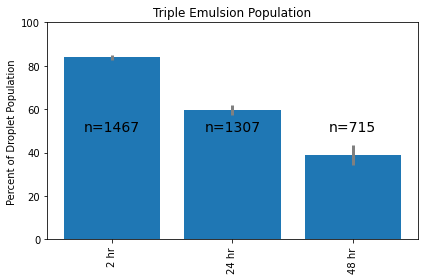

Day 2 71.10615932711396 3.7855744183618256
Day 3 46.22073417515364 6.20414295293707


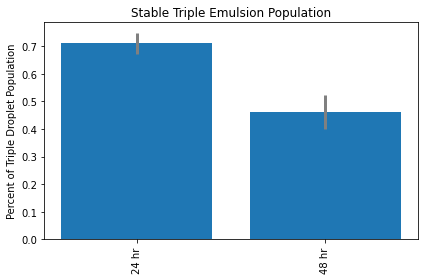

In [6]:
#Plot droplet populations as percentage of triple emulsions

#Containers for data
means = []
errors = []
ns = []
labels = ["Day 1", "Day 2", "Day 3"]

#Order data into arrays
#Calculate mean and standard deviation for each day
for dataset in [day1_data, day2_data, day3_data]:
    this_set = []
    day_n = 0
    for entry in dataset:
        triple_percent = 100*entry['triple']/entry['all']
        day_n += entry['all']
        this_set.append(triple_percent)
    triple_mean = np.mean(this_set)
    triple_error = np.std(this_set)
    means.append(triple_mean)
    errors.append(triple_error)
    ns.append(day_n)
    
for num in range(len(means)):
    print(labels[num],means[num], errors[num], ns[num])

#Plot bar plot with errors
plt.figure()
plt.title("Triple Emulsion Population")
plt.ylabel('Percent of Droplet Population')
plt.bar(['2 hr', '24 hr', '48 hr'], means)
plt.errorbar(x=['2 hr', '24 hr', '48 hr'], y=means,yerr=errors, ecolor='gray', linewidth=0, elinewidth=3.0)
for num in range(len(ns)):
    plt.text(num, 50, str("n=%d")%ns[num], horizontalalignment='center', fontsize=14)
plt.ylim(0,100)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("Fig3_triple_emulsion_population.pdf")
plt.show()


#Plot percentage of triple emulsion droplets remaining at 24 and 48 hours 

#Containers for data
stable_means = []
stable_errors = []

#Calculate survival as ratio of triple emulsion percents on each day compared to day one
#Re-calculate error as a percent of the the mean
#add error for numerator and denomenator and multiply by mean to get true error
base_error = errors[0]/means[0]
for num in range(len(means)-1):
    this_num = num+1
    this_mean = means[this_num]/means[0]
    stable_means.append(this_mean)
    this_error = errors[this_num]/means[this_num] + base_error
    total_error = this_mean * this_error
    stable_errors.append(total_error)
    
for num in range(len(stable_means)):
    print(labels[num+1],stable_means[num]*100, stable_errors[num]*100)

#Plot bar+error plot
plt.figure()
plt.title("Stable Triple Emulsion Population")
plt.ylabel('Percent of Triple Droplet Population')
plt.bar(['24 hr', '48 hr'], stable_means)
plt.errorbar(x=['24 hr', '48 hr'], y=stable_means,yerr=stable_errors, ecolor='gray', linewidth=0, elinewidth=3.0)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("Fig3_triple_emulsion_stable_population.pdf")
plt.show()

Triple radius, median: 34.03, mean: 33.56, stdev: 2.94


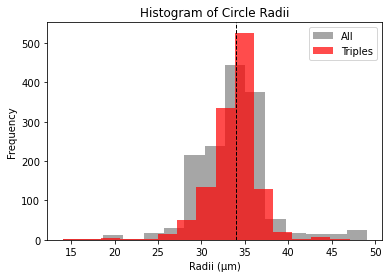

In [7]:
#Plot radii for all droplet and all just triple emulsions

#Set x-axis limits
circles_max_radius = 50
circles_min_radius = 5

#Containers for data
radii = []
triples_radii = []

#Organize radii data
for data_set in day1_data:
    radii.extend(data_set["radii"])
    triples_radii.extend(data_set["triples_radii"])

#Calculate statistics
median_triple_radius = np.median(triples_radii)
mean_triple_radius = np.mean(triples_radii)
std_triple_radius = np.std(triples_radii)

#Plot histogram
print(str("Triple radius, median: %.2f, mean: %.2f, stdev: %.2f")% (median_triple_radius, mean_triple_radius, std_triple_radius))
plt.figure()
plt.hist(radii, bins=int((circles_max_radius-circles_min_radius)/3), color='grey', alpha=0.7, label='All')
plt.hist(triples_radii, bins=int((circles_max_radius-circles_min_radius)/3), color='red', alpha=0.7, label='Triples')
plt.axvline(median_triple_radius, color='k', linestyle='dashed', linewidth=1)
plt.title('Histogram of Circle Radii')
plt.xlabel('Radii (µm)')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('Fig3_day1_radii_histogram.pdf')
